In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
import pickle


In [31]:
#leer el data
data = pd.read_csv('octavos_df.csv')
data.head()

,Equipo 1,Equipo 2,Temporada,goles_1,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,Leipzig,Manchester City,22/23,1,8,1,1,0,7
1,Brujas,Benfica,22/23,1,7,0,2,1,5
2,Liverpool,Real Madrid,22/23,2,6,2,5,0,1
3,Milan,Tottenham Hotspur,22/23,1,0,1,0,0,0
4,Eintracht Fráncfort,Napoli,22/23,0,5,0,2,0,3


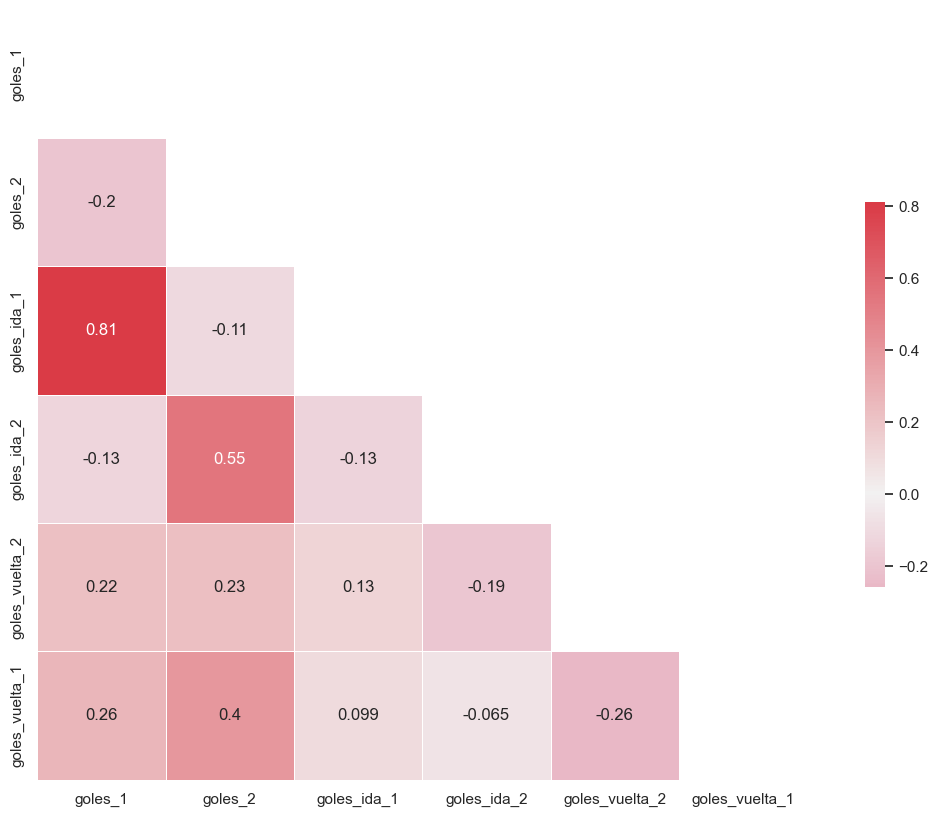

In [32]:
# Seleccionar solo las columnas numéricas
columnas_numericas = data.select_dtypes(include='number')

# Calcular la matriz de correlación
matriz_correlacion = columnas_numericas.corr()

# Crear el mapa de calor
plt.figure(figsize=(15, 10))
sns.set(style='white')

mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
cmap = sns.diverging_palette(0, 10, as_cmap=True)

sns.heatmap(matriz_correlacion,
            mask=mask,
            cmap=cmap,
            center=0,
            square=True,
            annot=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

plt.show()



In [33]:
#Las columnas no numéricas 'Equipo 1', 'Equipo 2' y 'Temporada' las paso a numéricas
#A cada equipos le asignaremos un número diferente (nuestro id) y para la temporada nos quedamos con el segundo año

import csv

equipos = set(data['Equipo 1']).union(set(data['Equipo 2']))
equipos_id = {equipo: i for i, equipo in enumerate(equipos)}

# Especificar el nombre del archivo CSV donde guardar la correspondencia
file_name = 'equipos_id.csv'

# Crear y escribir el archivo CSV
with open(file_name, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    # Escribir el encabezado
    writer.writerow(['Equipo', 'ID'])
    
    # Escribir cada equipo y su ID
    for equipo, id_equipo in equipos_id.items():
        writer.writerow([equipo, id_equipo])

print(f'Se guardó la correspondencia en {file_name}')

Se guardó la correspondencia en equipos_id.csv


In [34]:
#Una vez creados los ids hacemos el cambio en las columnas no numéricas

data['Equipo 1'] = data['Equipo 1'].map(equipos_id)
data['Equipo 2'] = data['Equipo 2'].map(equipos_id)
data['Temporada'] = data['Temporada'].apply(lambda x: int(x[-2:]))

# Guardar el DataFrame modificado en un mismo archivo CSV
data.to_csv('octavos_id.csv', index=False)

#Ahora mis equipos pasan a ser números

In [35]:
data.dtypes

Equipo 1          int64
Equipo 2          int64
Temporada         int64
goles_1           int64
goles_2           int64
goles_ida_1       int64
goles_ida_2       int64
goles_vuelta_2    int64
goles_vuelta_1    int64
dtype: object

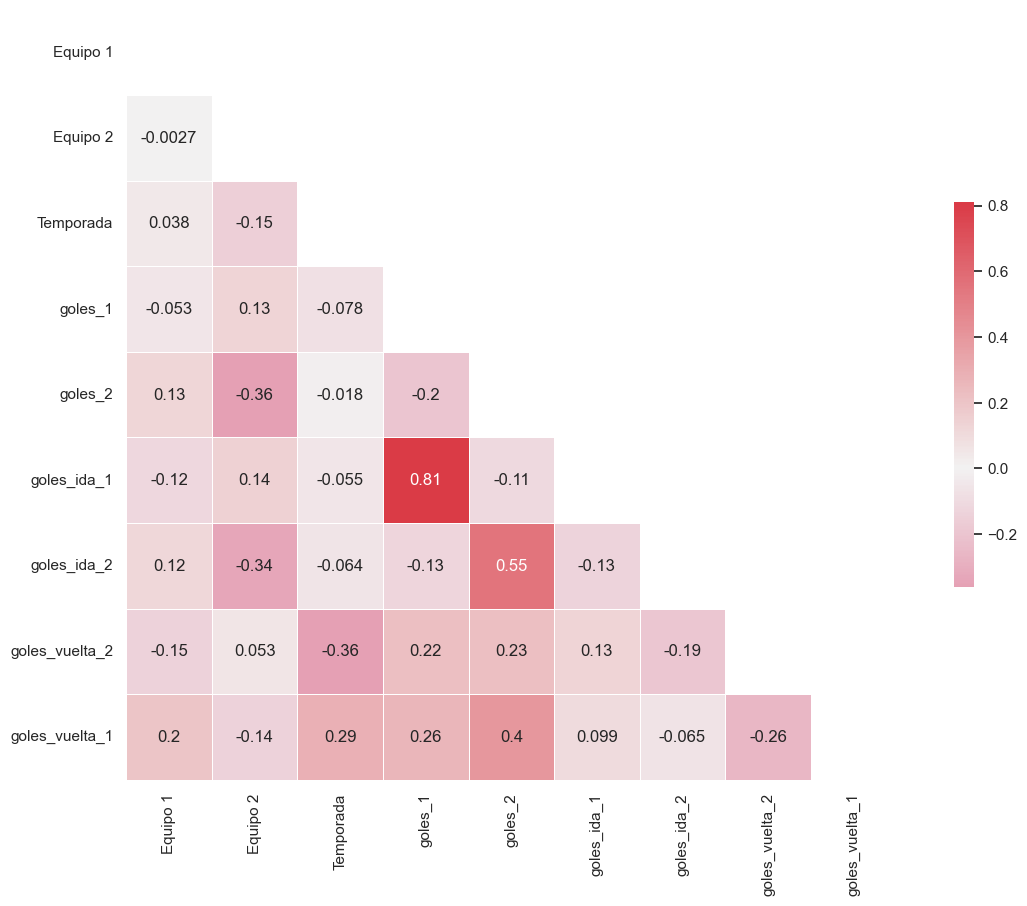

In [36]:
# Seleccionar solo las columnas numéricas
columnas_numericas = data.select_dtypes(include='number')

# Calcular la matriz de correlación
matriz_correlacion = columnas_numericas.corr()

# Crear el mapa de calor
plt.figure(figsize=(15, 10))
sns.set(style='white')

mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
cmap = sns.diverging_palette(0, 10, as_cmap=True)

sns.heatmap(matriz_correlacion,
            mask=mask,
            cmap=cmap,
            center=0,
            square=True,
            annot=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

plt.show()

Modelo de regresión lineal para predecir primero los goles marcados por el equipo1, aprendizaje supervisado

In [37]:
df = pd.read_csv('octavos_id.csv')
df.head()

,Equipo 1,Equipo 2,Temporada,goles_1,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,41,1,23,1,8,1,1,0,7
1,9,2,23,1,7,0,2,1,5
2,14,40,23,2,6,2,5,0,1
3,3,45,23,1,0,1,0,0,0
4,32,34,23,0,5,0,2,0,3


In [38]:
x = df.drop('goles_1', axis=1)
y = df['goles_1'] #Ahora vamos a predecir los goles del equipo 1, también podremos predecir los goles del equipo 2

In [39]:
#Dividimos los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [40]:
#Normalizamos los datos de entrenamiento y los guardamos en un fichero para su uso futuro
pt = PowerTransformer()
pt.fit(x_train)
with open('/Users/carlotasanchezgonzalez/Documents/class/Champions_23-24/scalers/octavos_scaler.pkl', 'wb') as f:
    pickle.dump(pt, f)

In [41]:
#Normalizamos los datos para que se asemeje a una distribución normal y así mejorar el rendimiento del modelo
x_train_scaled = pt.transform(x_train)
x_test_scaled = pt.transform(x_test)

y_train_scaled = np.log1p(y_train)

#Y lo guardamos en dataframes
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)

x_train_scaled


,Equipo 1,Equipo 2,Temporada,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,-0.006994,0.189225,-0.371385,-0.141698,-1.260946,0.615537,-0.128615,-1.280515
1,1.283465,-1.691702,-1.380766,1.240101,-1.260946,1.554102,0.634722,-0.129810
2,1.368085,0.137602,1.286741,-1.309766,0.871652,-1.364606,0.634722,-0.129810
3,1.066788,0.931630,0.626725,0.353156,-1.260946,-0.121332,-1.462661,0.995362
4,0.101660,1.220372,-0.037526,-0.141698,0.871652,0.615537,-0.128615,0.531436
...,...,...,...,...,...,...,...,...
65,-0.006994,0.189225,0.957236,0.353156,0.871652,-0.121332,0.634722,0.995362
66,0.259443,0.577566,-0.706491,0.810965,-1.260946,0.615537,1.168836,-0.129810
67,1.283465,0.802214,-1.042922,-1.309766,0.131700,-1.364606,-0.128615,-1.280515
68,-1.040594,-0.432957,1.286741,-0.687347,-1.260946,0.615537,-0.128615,-1.280515


In [42]:
#Ahora creo el modelod de regresión lineal y lo entrenamos
model = LinearRegression()
model.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [43]:
#Realizar predicciones 
y_pred = model.predict(x_test_scaled)
y_pred

array([1.52300074, 0.5898867 , 2.40556752, 1.68168967, 1.00668314,
       1.15996954, 1.33802911, 0.2154531 , 0.23308426, 0.80907862,
       1.1196474 , 0.06479397, 0.6162418 , 0.25483589, 0.80661475,
       1.46448492, 0.93441608, 0.95865772])

In [44]:
#Evaluamos del modelo para ver la calidad de las predcciones

# Deshacer la transformación logarítmica para obtener las predicciones en la escala original
y_pred_original_scale = np.expm1(y_pred)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred_original_scale)

# Calcular el Coeficiente de Determinación (R²)
r2 = r2_score(y_test, y_pred_original_scale)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse = np.sqrt(mse)

# Imprimir las métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 0.6151010852328178
R-squared (R²): 0.8397968234602629
Root Mean Squared Error (RMSE): 0.7842838040102689
